In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import MaxPool2D, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [55]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [56]:
x_train = train.drop('label', axis=1)
y_train = train['label']

In [57]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [58]:
print(x_train.isnull().sum().any())
print(y_train.isnull().sum().any())

False
False


In [59]:
x_train = x_train/255.0
test = test/255.0
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [60]:
y_train = to_categorical(y_train, num_classes=10)

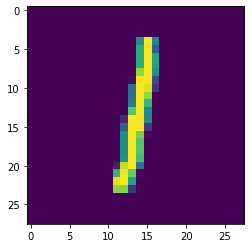

In [61]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=0.5, random_state=5)
plt.imshow(x_train[1])

In [62]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.45))
model.add(Dense(10, activation = "softmax"))

In [73]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=10,verbose=1,factor=0.0125,min_lr=0.00001)                                          
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)
history = model.fit(datagen.flow(x_train,y_train, batch_size=25),
                              epochs = 1, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0], callbacks=[learning_rate_reduction])

21000/21000 [==============================] - 15s 658us/step - loss: 0.1135 - accuracy: 0.9669 - val_loss: 0.0438 - val_accuracy: 0.9883


Test accuracy: 98.8286%


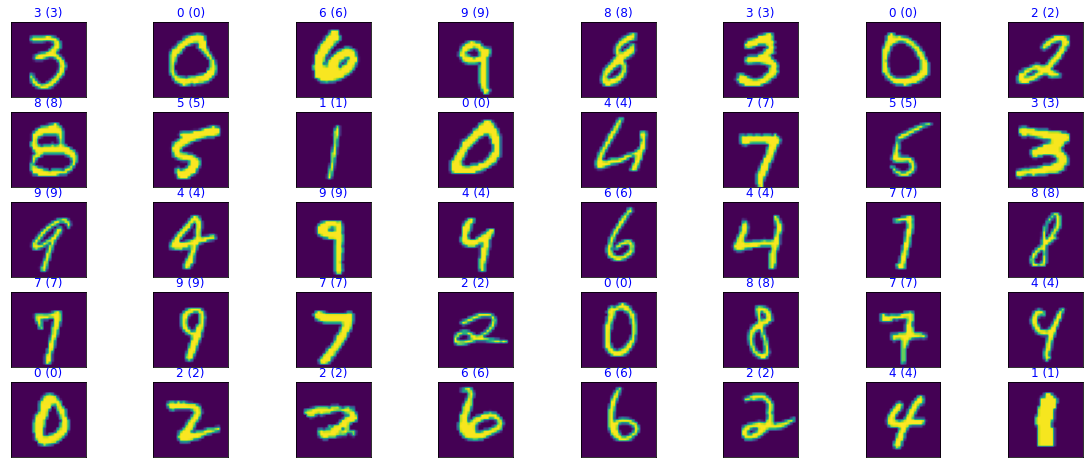

In [74]:
# Predict the values from the validation dataset
y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1)
y_pred_classes
# evaluate test accuracy
score = model.evaluate(x_val, y_val, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

labels = ['0','1','2','3','4','5','6','7','8','9']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_val.shape[0], size=40, replace=False)):
    ax = fig.add_subplot(5, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_val[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_val[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [75]:
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)